**Imports**

In [1]:
!pip install evaluate
import time
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          Seq2SeqTrainer, Seq2SeqTrainingArguments,
                          DataCollatorForSeq2Seq)
import evaluate
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

2025-04-13 15:12:45.612453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744557166.079181      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744557166.212558      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Data Loading and Preprocessing**

In [2]:
# Data Loading (Using Raw Text, With Punctuations etc.)
TRAIN_FILE = '/kaggle/input/dataaaa/train.csv'
TEST_FILE  = '/kaggle/input/dataaaa/test.csv'

def load_csv_safely(file_path):
    try:
        return pd.read_csv(
            file_path,
            encoding='latin-1',
            error_bad_lines=False,
            on_bad_lines='skip',
            quoting=3
        )
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()
print("Loading training data...")
df = pd.read_csv(TRAIN_FILE, encoding='latin-1')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(subset=['text', 'title'], inplace=True)
df = df[df['text'].str.strip().astype(bool) & df['title'].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)

# Split the raw data into training and validation sets.
print("Splitting data into train and validation sets...")
train_df, valid_df = train_test_split(df, test_size=500, random_state=42, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print("Loading test data...")
test_df = pd.read_csv(TEST_FILE, encoding='latin-1')
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]
test_df.dropna(subset=['text', 'title'], inplace=True)
test_df = test_df[test_df['text'].str.strip().astype(bool) & test_df['title'].str.strip().astype(bool)]
test_df.reset_index(drop=True, inplace=True)

print("Data sizes:")
print("Train set:", len(train_df))
print("Validation set:", len(valid_df))
print("Test set:", len(test_df))


Loading training data...
Splitting data into train and validation sets...
Loading test data...
Data sizes:
Train set: 13379
Validation set: 500
Test set: 100


**Custom Dataset Class for Seq2Seq Fine-Tuning**

In [3]:
# Define a custom Dataset for Seq2Seq Fine-Tuning
class TitleDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_length=512, max_target_length=64, is_test=False):
        self.inputs = df['text'].tolist()
        self.targets = df['title'].tolist() if not is_test else None
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.is_test = is_test

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        model_inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors='pt'
        )
        # Remove the batch dimension
        model_inputs = {k: v.squeeze() for k, v in model_inputs.items()}
        if not self.is_test:
            target_text = self.targets[idx]
            # Tokenize target text
            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(
                    target_text,
                    max_length=self.max_target_length,
                    truncation=True,
                    padding="max_length",
                    return_tensors='pt'
                )
            model_inputs["labels"] = labels.input_ids.squeeze()
        return model_inputs

**Task c1: Fine-Tuning T5-Small model on raw text.**


In [26]:
class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        # If labels are not in inputs or are None, directly generate predictions.
        if "labels" not in inputs or inputs["labels"] is None:
            model_for_generate = model.module if hasattr(model, "module") else model
            generated_tokens = model_for_generate.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=self.args.generation_max_length or 64,
                num_beams=4,
                early_stopping=True,
            )
            return (None, generated_tokens, None)
        else:
            # Otherwise fall back to the default method.
            return super().prediction_step(model, inputs, prediction_loss_only, ignore_keys)

from tqdm.auto import tqdm

# Task c1: Fine-Tuning google/t5-small
print("\n Task c1: Fine-Tuning T5-Small ")

# 1. Load the pretrained model & tokenizer (using raw text)
print("\nLoading pretrained model and tokenizer...")
with tqdm(total=2, desc="Model and Tokenizer Load") as pbar:
    model_name_c1 = "t5-small"
    tokenizer_c1 = AutoTokenizer.from_pretrained(model_name_c1)
    pbar.update(1)
    model_c1 = AutoModelForSeq2SeqLM.from_pretrained(model_name_c1)
    pbar.update(1)

# Create dataset objects using raw text (no pre-cleaning)
print("\nPreparing datasets...")
with tqdm(total=3, desc="Dataset Preparation") as pbar:
    train_dataset = TitleDataset(train_df, tokenizer_c1, max_input_length=512, max_target_length=64)
    pbar.update(1)
    valid_dataset = TitleDataset(valid_df, tokenizer_c1, max_input_length=512, max_target_length=64)
    pbar.update(1)
    test_dataset = TitleDataset(test_df, tokenizer_c1, max_input_length=512, max_target_length=64, is_test=True)
    pbar.update(1)

# Data collator (handles dynamic padding)
data_collator = DataCollatorForSeq2Seq(tokenizer_c1, model=model_c1)

# 2. Set up training arguments
print("\nSetting up training arguments...")
training_args = Seq2SeqTrainingArguments(
    output_dir='./t5_small_results',
    eval_strategy="epoch",
    run_name="motu",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to=[]
)

# Create the Seq2SeqTrainer
trainer = CustomSeq2SeqTrainer(
    model=model_c1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer_c1,
    data_collator=data_collator
)

# 3. Fine-tune the model and time the training (only the training call here is timed)
print("Training T5-small model...")
start_train = time.time()
with tqdm(total=training_args.num_train_epochs, desc="Training Progress") as pbar:
    for epoch in range(training_args.num_train_epochs):
        trainer.train()
        pbar.update(1)
train_duration = time.time() - start_train
print(f"Training completed in {train_duration:.2f} seconds.")




 Task c1: Fine-Tuning T5-Small 

Loading pretrained model and tokenizer...


Model and Tokenizer Load:   0%|          | 0/2 [00:00<?, ?it/s]


Preparing datasets...


Dataset Preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Setting up training arguments...
Training T5-small model...


/tmp/ipykernel_31/4025705899.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomSeq2SeqTrainer(


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.043800,0.036576
2,0.040300,0.032717
3,0.035700,0.031367


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separat

Epoch,Training Loss,Validation Loss
1,0.030000,0.028923
2,0.030200,0.027932
3,0.028200,0.027636


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separat

Epoch,Training Loss,Validation Loss
1,0.024700,0.026564
2,0.025600,0.025953
3,0.023900,0.026202


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separat

Training completed in 4777.69 seconds.


**Generate Predictions on the Test Set**

In [37]:
!pip install rouge-score
import numpy as np
# Greedy Decoding using Seq2SeqTrainer.predict
print("\nGenerating predictions (Greedy Decoding)...")
start_pred_greedy = time.time()
with tqdm(total=1, desc="Greedy Decoding") as pbar:
    predictions_output = trainer.predict(test_dataset)
    pbar.update(1)
    
# predictions_output.predictions is already a NumPy array, convert each sequence
predictions_ids = predictions_output.predictions.tolist()
max_token_id = tokenizer_c1.vocab_size - 1

# Convert each sequence into a NumPy array of int32 and decode
decoded_preds_greedy = [
    tokenizer_c1.decode(
        [min(max(0, int(token_id)), max_token_id) for token_id in seq],
        skip_special_tokens=True
    )
    for seq in predictions_ids
]
pred_greedy_time = time.time() - start_pred_greedy
print(f"Greedy generation completed in {pred_greedy_time:.2f} seconds.")

# Print sample outputs for Greedy Decoding (first 5 examples)
print("\nSample Greedy Decoding Outputs:")
for i in range(5):
    input_snippet = test_df['text'].iloc[i][:100]  # show first 100 characters of input
    reference_title = test_df['title'].iloc[i]
    generated_title = decoded_preds_greedy[i]
    print(f"Sample {i+1}:")
    print(f"Input (snippet): {input_snippet}...")
    print(f"Reference Title: {reference_title}")
    print(f"Greedy Prediction: {generated_title}")
    print("-" * 50)

# Beam Search Decoding
print("\nGenerating predictions (Beam Search Decoding)...")
start_pred_beam = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_c1.to(device)
beam_predictions = []
test_loader = DataLoader(test_dataset, batch_size=8)
for batch in tqdm(test_loader, desc="Beam search generation"):
    # Move inputs to device (labels are not needed for generation)
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    with torch.no_grad():
        generated_ids = model_c1.generate(**inputs, num_beams=4, early_stopping=True)
    preds = tokenizer_c1.batch_decode(generated_ids, skip_special_tokens=True)
    beam_predictions.extend(preds)
pred_beam_time = time.time() - start_pred_beam
print(f"Beam search generation completed in {pred_beam_time:.2f} seconds.")

print("\nSample Beam Search Decoding Outputs:")
for i in range(5):
    input_snippet = test_df['text'].iloc[i][:100]  # show first 100 characters of input
    reference_title = test_df['title'].iloc[i]
    generated_title = beam_predictions[i]
    print(f"Sample {i+1}:")
    print(f"Input (snippet): {input_snippet}...")
    print(f"Reference Title: {reference_title}")
    print(f"Beam Prediction: {generated_title}")
    print("-" * 50)

# Evaluate ROUGE Metrics
print("\nEvaluating ROUGE metrics...")
rouge_metric = evaluate.load("rouge")
with tqdm(total=1, desc="ROUGE Evaluation") as pbar:
    # Use ground truth titles from test set for evaluation
    references = test_df['title'].tolist()
    rouge_results_greedy = rouge_metric.compute(predictions=decoded_preds_greedy, references=references)
    rouge_results_beam = rouge_metric.compute(predictions=beam_predictions, references=references)
    pbar.update(1)

print("\nROUGE scores for Greedy Decoding:")
print(rouge_results_greedy)
print("\nROUGE scores for Beam Search Decoding:")
print(rouge_results_beam)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Generating predictions (Greedy Decoding)...


Greedy Decoding:   0%|          | 0/1 [00:00<?, ?it/s]

Greedy Decoding: 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Greedy generation completed in 5.75 seconds.

Sample Greedy Decoding Outputs:
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Greedy Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Title: Catholic High School, Singapore
Greedy Prediction: Catholic High School
--------------------------------------------------
Sample 3:
Input (snippet): The Minnesota Golden Gophers (commonly shortened to Gophers) are the college sports teams of the Uni...
Reference Title: Minnesota Golden Gophers
Greedy Prediction: Minnesota Golden Gophers
--------------------------------------------------
Sample 4:
Input (snippet): The following are notable people who were either born, raised, or have lived for a significant perio...
Refe

Beam search generation: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Beam search generation completed in 5.23 seconds.

Sample Beam Search Decoding Outputs:
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Beam Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Title: Catholic High School, Singapore
Beam Prediction: Catholic High School
--------------------------------------------------
Sample 3:
Input (snippet): The Minnesota Golden Gophers (commonly shortened to Gophers) are the college sports teams of the Uni...
Reference Title: Minnesota Golden Gophers
Beam Prediction: Minnesota Golden Gophers
--------------------------------------------------
Sample 4:
Input (snippet): The following are notable people who were either born, raised, or have lived for a significant perio...


ROUGE Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


ROUGE scores for Greedy Decoding:
{'rouge1': 0.8971172161172163, 'rouge2': 0.6991363636363637, 'rougeL': 0.8959999999999999, 'rougeLsum': 0.8972820512820513}

ROUGE scores for Beam Search Decoding:
{'rouge1': 0.8971172161172163, 'rouge2': 0.6991363636363637, 'rougeL': 0.8959999999999999, 'rougeLsum': 0.8972820512820513}



Task c1 ROUGE F1 Scores (Finetuned T5-Small):
  Decoding   ROUGE-1   ROUGE-2  ROUGE-L
0   Greedy  0.897117  0.699136    0.896
1     Beam  0.897117  0.699136    0.896


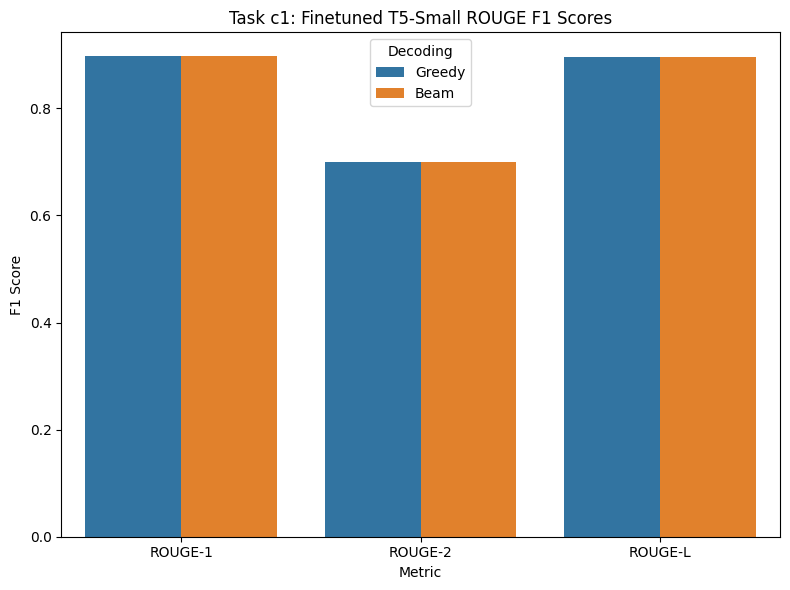

In [38]:
# Here, we store them in a list along with the decoding method.
data_c1 = []
for decoding_method, scores in zip(["Greedy", "Beam"], [rouge_results_greedy, rouge_results_beam]):
    data_c1.append({
        "Decoding": decoding_method,
        "ROUGE-1": scores["rouge1"],
        "ROUGE-2": scores["rouge2"],
        "ROUGE-L": scores["rougeL"]
    })

df_c1 = pd.DataFrame(data_c1)
print("\nTask c1 ROUGE F1 Scores (Finetuned T5-Small):")
print(df_c1)

# Plot Task c1 Results
plt.figure(figsize=(8,6))
df_c1_melt = df_c1.melt(id_vars=["Decoding"], var_name="Metric", value_name="F1")
sns.barplot(x="Metric", y="F1", hue="Decoding", data=df_c1_melt)
plt.title("Task c1: Finetuned T5-Small ROUGE F1 Scores")
plt.ylabel("F1 Score")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

**Task c2: FLAN-T5 with Prompt Variations,Evaluate using 2 different prompts**


In [ ]:
# Task c2: Using FLAN-T5 with Prompt Variations
def generate_with_prompts(model, tokenizer, df, prompt_variants, decoding_strategy="beam",
                          max_input_length=512, max_target_length=64, num_beams=4):
    """
    Generates predictions for each prompt variant using the specified decoding strategy.
    For 'beam' decoding, num_beams is used; for 'greedy', num_beams=1.
    Returns a dictionary mapping prompt variant to list of predictions and the reference titles.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    predictions = {prompt: [] for prompt in prompt_variants}
    test_texts = df['text'].tolist()
    test_targets = df['title'].tolist()  # For evaluation
    
    for prompt in prompt_variants:
        print(f"\n[{decoding_strategy.capitalize()}] Generating predictions with prompt: '{prompt}'")
        preds = []
        for text in tqdm(test_texts, desc="Prompt generation"):
            input_text = prompt + text
            inputs = tokenizer(input_text, max_length=max_input_length, truncation=True, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                if decoding_strategy == "beam":
                    generated_ids = model.generate(**inputs,
                                                   num_beams=num_beams,
                                                   max_length=max_target_length,
                                                   early_stopping=True)
                elif decoding_strategy == "greedy":
                    # For greedy search, simply use default generate settings
                    generated_ids = model.generate(**inputs,
                                                   max_length=max_target_length,
                                                   early_stopping=True)
                else:
                    raise ValueError("decoding_strategy must be either 'beam' or 'greedy'")
            decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            preds.append(decoded)
        predictions[prompt] = preds
        
    return predictions, test_targets

# Setup for FLAN-T5 models and prompts
# Two prompt variants
prompt_variants = [
    "Generate a concise title for the following article: ",
    "What would be a good title for the following text? "
]

# List of FLAN-T5 models
flan_models = {
    "flan-t5-base": "google/flan-t5-base",
    "flan-t5-large": "google/flan-t5-large"
}

# Load the ROUGE metric once
rouge_metric = evaluate.load("rouge")

# Dictionary to store all ROUGE results:
# Structure: { model_name: { prompt_variant: { decoding_strategy: { ... rouge scores ... } } } }
flan_results = {}

# Dictionary to also store predictions (if you wish to inspect sample outputs later)
flan_predictions = {}

# Assuming your test dataset is in test_df (a pandas DataFrame) with columns 'text' and 'title'
# For demonstration, we assume test_df is already loaded.

for model_key, model_name in flan_models.items():
    print(f"\nLoading model: {model_name}")
    tokenizer_flan = AutoTokenizer.from_pretrained(model_name)
    model_flan = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    
    # Initialize storage for this model
    flan_results[model_name] = {prompt: {} for prompt in prompt_variants}
    flan_predictions[model_name] = {prompt: {} for prompt in prompt_variants}
    
    # For each decoding strategy, generate predictions per prompt variant, then compute ROUGE.
    for strategy in ["greedy", "beam"]:
        preds_dict, references = generate_with_prompts(model_flan, tokenizer_flan, test_df,
                                                       prompt_variants, decoding_strategy=strategy,
                                                       max_input_length=512, max_target_length=64,
                                                       num_beams=4)
        # Store predictions for later inspection.
        for prompt in prompt_variants:
            flan_predictions[model_name][prompt][strategy] = preds_dict[prompt]
            # Compute ROUGE scores for this combination
            rouge_results = rouge_metric.compute(predictions=preds_dict[prompt], references=references)
            flan_results[model_name][prompt][strategy] = rouge_results
            print(f"\nModel: {model_name}, Prompt: '{prompt}', Decoding: {strategy}")
            print("ROUGE scores:", rouge_results)


        # Optionally, print a few sample predictions for this model:
        for prompt, preds in predictions_dict.items():
            print(f"\nSample Predictions for model {model_name} with prompt: '{prompt}'")
            for i in range(5):
                input_snippet = test_df['text'].iloc[i][:100]  # first 100 characters
                reference_title = test_df['title'].iloc[i]
                generated_title = preds[i]
                print(f"Sample {i+1}:")
                print(f"Input (snippet): {input_snippet}...")
                print(f"Reference Title: {reference_title}")
                print(f"Prediction: {generated_title}")
                print("-" * 50)

# Task c2: Plotting ROUGE Scores for FLAN-T5 Models
# Convert the stored results into a Pandas DataFrame for plotting.
data_c2 = []
for model_name, prompt_dict in flan_results.items():
    for prompt, strategy_dict in prompt_dict.items():
        for decoding_strat, scores in strategy_dict.items():
            # We assume rouge_metric.compute returns a dict with keys "rouge1", "rouge2", "rougeL"
            data_c2.append({
                "Model": model_name,
                "Prompt": prompt,
                "Decoding": decoding_strat.capitalize(),
                "ROUGE-1": scores["rouge1"],
                "ROUGE-2": scores["rouge2"],
                "ROUGE-L": scores["rougeL"]
            })

df_c2 = pd.DataFrame(data_c2)
print("\nCombined Task c2 Results:")
print(df_c2)


Loading model: google/flan-t5-base

[Greedy] Generating predictions with prompt: 'Generate a concise title for the following article: '


Prompt generation:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Prompt generation: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]



[Greedy] Generating predictions with prompt: 'What would be a good title for the following text? '


Prompt generation: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]



Model: google/flan-t5-base, Prompt: 'Generate a concise title for the following article: ', Decoding: greedy
ROUGE scores: {'rouge1': 0.794507076257076, 'rouge2': 0.5808888888888888, 'rougeL': 0.7869048451548449, 'rougeLsum': 0.7883561438561435}

Model: google/flan-t5-base, Prompt: 'What would be a good title for the following text? ', Decoding: greedy
ROUGE scores: {'rouge1': 0.5671142746142741, 'rouge2': 0.3486987734487734, 'rougeL': 0.5636043956043953, 'rougeLsum': 0.5624461926961923}

Sample Predictions for model google/flan-t5-base with prompt: 'Generate a concise title for the following article: '
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Title:

Prompt generation: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]



[Beam] Generating predictions with prompt: 'What would be a good title for the following text? '


Prompt generation: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]



Model: google/flan-t5-base, Prompt: 'Generate a concise title for the following article: ', Decoding: beam
ROUGE scores: {'rouge1': 0.7845277777777777, 'rouge2': 0.554, 'rougeL': 0.7787738095238093, 'rougeLsum': 0.7809920634920633}

Model: google/flan-t5-base, Prompt: 'What would be a good title for the following text? ', Decoding: beam
ROUGE scores: {'rouge1': 0.6374573759573757, 'rouge2': 0.4342510822510821, 'rougeL': 0.6352295629207392, 'rougeLsum': 0.6358092789563374}

Sample Predictions for model google/flan-t5-base with prompt: 'Generate a concise title for the following article: '
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Title: Catholic High S

Prompt generation: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]



[Greedy] Generating predictions with prompt: 'What would be a good title for the following text? '


Prompt generation: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]



Model: google/flan-t5-large, Prompt: 'Generate a concise title for the following article: ', Decoding: greedy
ROUGE scores: {'rouge1': 0.861025974025974, 'rouge2': 0.6379999999999999, 'rougeL': 0.8588354978354975, 'rougeLsum': 0.8611450216450217}

Model: google/flan-t5-large, Prompt: 'What would be a good title for the following text? ', Decoding: greedy
ROUGE scores: {'rouge1': 0.7604837384837384, 'rouge2': 0.5342551141668788, 'rougeL': 0.7517512838039152, 'rougeLsum': 0.7529487150276621}

Sample Predictions for model google/flan-t5-large with prompt: 'Generate a concise title for the following article: '
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Tit

Prompt generation: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]



[Beam] Generating predictions with prompt: 'What would be a good title for the following text? '


Prompt generation: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]



Model: google/flan-t5-large, Prompt: 'Generate a concise title for the following article: ', Decoding: beam
ROUGE scores: {'rouge1': 0.8751309523809524, 'rouge2': 0.6509999999999999, 'rougeL': 0.8740238095238094, 'rougeLsum': 0.8739404761904762}

Model: google/flan-t5-large, Prompt: 'What would be a good title for the following text? ', Decoding: beam
ROUGE scores: {'rouge1': 0.7723682428682428, 'rouge2': 0.5776880619380618, 'rougeL': 0.7698664113664113, 'rougeLsum': 0.7725500888000887}

Sample Predictions for model google/flan-t5-large with prompt: 'Generate a concise title for the following article: '
Sample 1:
Input (snippet): Weyburn is the eleventh-largest city in Saskatchewan, Canada. The city has a population of 10,870. I...
Reference Title: Weyburn
Prediction: Weyburn, Saskatchewan
--------------------------------------------------
Sample 2:
Input (snippet): Catholic High School (CHS) is a government-aided autonomous Catholic boys' school in Bishan, Singapo...
Reference Title:

**Visualizations**

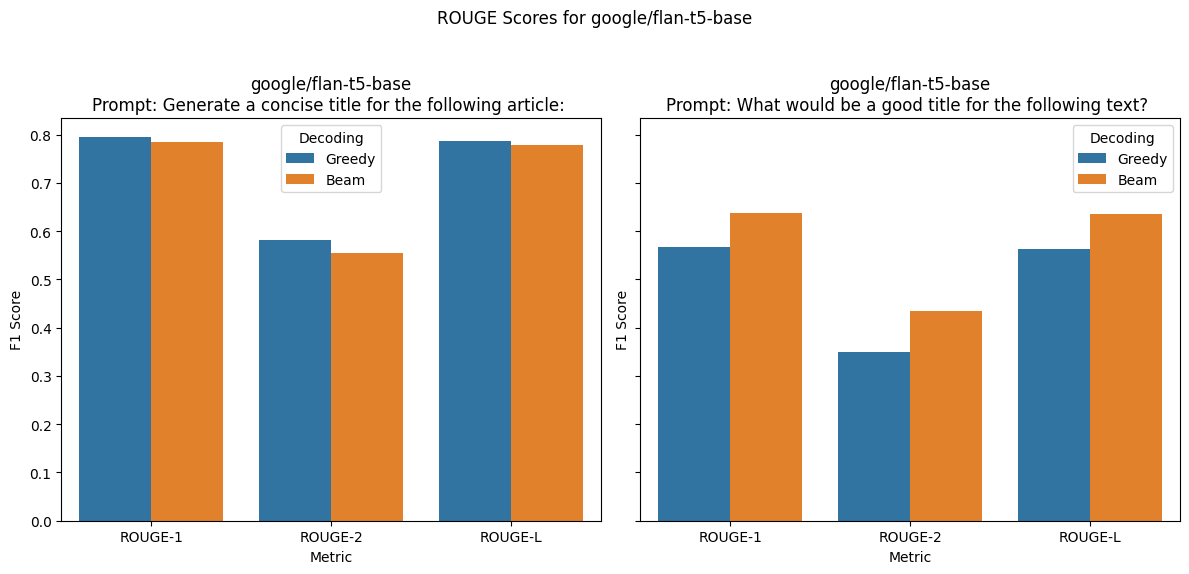

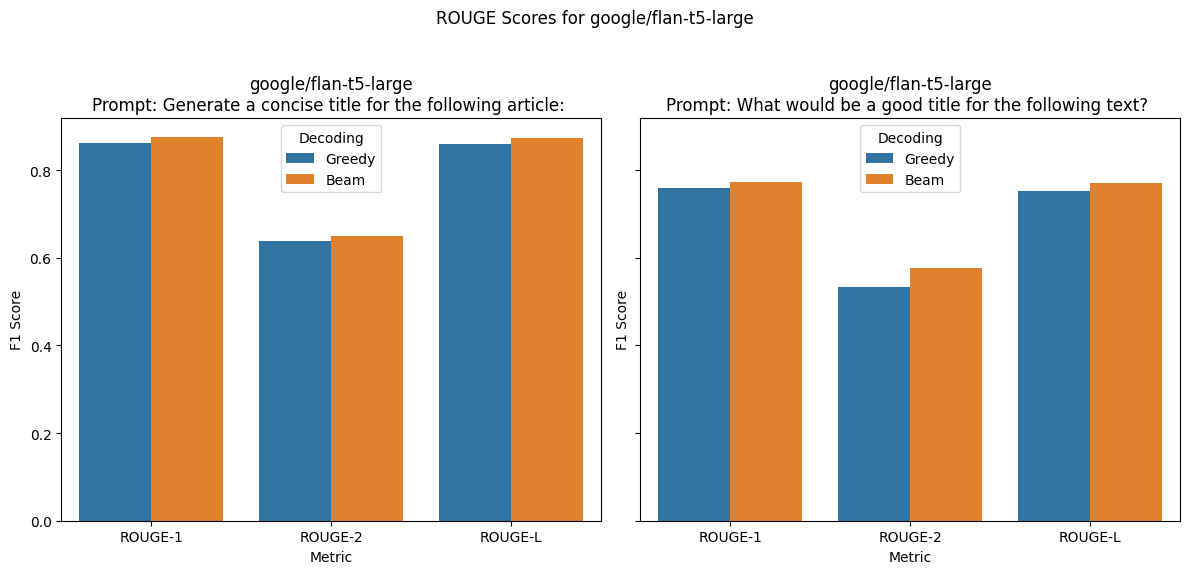

In [40]:
# Plot Task c2 Results
for model_name in flan_models.values():
    # Subset the DataFrame for this model
    df_model = df_c2[df_c2["Model"] == model_name]
    # Melt the DataFrame so that each metric becomes a row
    df_model_melt = df_model.melt(id_vars=["Prompt", "Decoding"], 
                                  value_vars=["ROUGE-1", "ROUGE-2", "ROUGE-L"],
                                  var_name="Metric", value_name="F1")
    
    # Create a figure with one subplot per prompt variant
    prompt_variants_unique = df_model_melt["Prompt"].unique()
    n_prompts = len(prompt_variants_unique)
    fig, axes = plt.subplots(nrows=1, ncols=n_prompts, figsize=(6*n_prompts, 6), sharey=True)
    if n_prompts == 1:
        axes = [axes]
    for ax, prompt in zip(axes, prompt_variants_unique):
        df_prompt = df_model_melt[df_model_melt["Prompt"] == prompt]
        sns.barplot(x="Metric", y="F1", hue="Decoding", data=df_prompt, ax=ax)
        ax.set_title(f"{model_name}\nPrompt: {prompt}")
        ax.set_ylabel("F1 Score")
        ax.set_xlabel("Metric")
        ax.legend(title="Decoding")
    plt.suptitle(f"ROUGE Scores for {model_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()